In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import umap
import time
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from scipy.stats import zscore

### Load the abundance

In [2]:
abundance_maps = (np.load('../../../primary_data/abundance_maps.npz')['arr_0'])/255
print(abundance_maps.shape)

# select the abundance maps to be considered
indices = [3,4,6,1,9,7]
colors = [[1,0,0], [0,1,0], [0,0,1], [0,1,1], [1,0,1], [1,1,0]]

abundance_maps = abundance_maps[indices,:,:,:]
print(abundance_maps.shape)

(11, 1024, 1024, 30)
(6, 1024, 1024, 30)


### load the data folder

In [3]:
spectrum_folder = '../../../primary_data/main_mosaic_6by5/Spectrum2D_PC10/'
file_names = []
tmp = os.listdir(spectrum_folder)
for filename in tmp:
    if filename.endswith('.npz'):
        file_names.append(filename)

file_names = sorted(file_names)
files = [os.path.join(spectrum_folder,file_name) for file_name in file_names]


### subsample from all the tiles the spectrum 2D 

In [ ]:
subsample_size = int(0.1*1024**2)
np.random.rand(100); sample = np.random.choice(1024**2, subsample_size)

spectrum_2D = np.zeros((subsample_size*abundance_maps.shape[3],250))

for tile_idx in range(abundance_maps.shape[3]):
    # data
    spectrum_2D[tile_idx*subsample_size:(tile_idx+1)*subsample_size,:] =  np.load(files[tile_idx])['spectrum_2D'][sample,:]
    print(tile_idx,end='\r')

### get the corresponding RGBA colors

In [6]:
colors_list = np.zeros((subsample_size*abundance_maps.shape[3],4))   #RGBA

for tile_idx in range(abundance_maps.shape[3]):
    # color
    max_color_tile = np.argmax(abundance_maps[:,:,:,tile_idx],axis=0)
    alpha_tile = np.max(abundance_maps[:,:,:,tile_idx],axis=0)
    
    # reshape
    max_color_tile = max_color_tile.reshape((1024**2))
    alpha_tile = alpha_tile.reshape(((1024**2)))
    
    # set RGB then A
    colors_list[tile_idx*subsample_size:(tile_idx+1)*subsample_size,0:3] = [colors[i] for i in max_color_tile[sample]]
    colors_list[tile_idx*subsample_size:(tile_idx+1)*subsample_size,3] = [alpha_tile[i] for i in max_color_tile[sample]]
    

### Apply umap

In [ ]:
umap_metrics = ['canberra','correlation','minkowski']

for umap_metric in umap_metrics:
    # Apply UMAP directly
    start = datetime.now()
    #umap_metric = 'chebyshev'
    umap1 = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.0, metric=umap_metric,random_state=100)
    embeddings = umap1.fit_transform(spectrum_2D)

    end = datetime.now()
    # if 3 dimensions for UMAP, which ones to use (0,1,or 2)
    dim_a = 0
    dim_b = 1

    # scaling
    scaler = MinMaxScaler()
    #embeddings = scaler.fit_transform(embeddings)

    etime = end-start
    print('Duration for UMAP fitting: {}'.format(end - start))


    f, ax = plt.subplots(figsize=(20,20))
    sns.despine(left=True, bottom=True, right=True)
    ax.set_facecolor("black")
    ax.scatter(MinMaxScaler(feature_range=(0,1)).fit_transform(embeddings[:,dim_a].reshape(-1, 1)),MinMaxScaler(feature_range=(0,1)).fit_transform(embeddings[:,dim_b].reshape(-1, 1)), s=0.05,c=colors_list,marker='o') 
    ax.set_aspect('equal')
    f.tight_layout() 


    #plt.axis('off')
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)



    #plt.show()
    plt.savefig('../../../primary_data/other_png/Figure_6_zscored_%s.png' % umap_metric,dpi=300)


/Users/aj/Desktop/work/virtualenvs/edx/lib/python3.9/site-packages/umap/spectral.py:342: UserWarning: Exited at iteration 20 with accuracies 
[0.01973181 0.01758181 0.02198188]
not reaching the requested tolerance 1e-08.
  eigenvalues, eigenvectors = scipy.sparse.linalg.lobpcg(


Duration for UMAP fitting: 0:22:38.013928


/Users/aj/Desktop/work/virtualenvs/edx/lib/python3.9/site-packages/umap/spectral.py:342: UserWarning: Exited at iteration 20 with accuracies 
[0.02170205 0.02246895 0.0209982 ]
not reaching the requested tolerance 1e-08.
  eigenvalues, eigenvectors = scipy.sparse.linalg.lobpcg(


Duration for UMAP fitting: 0:19:15.190506


### Visualize

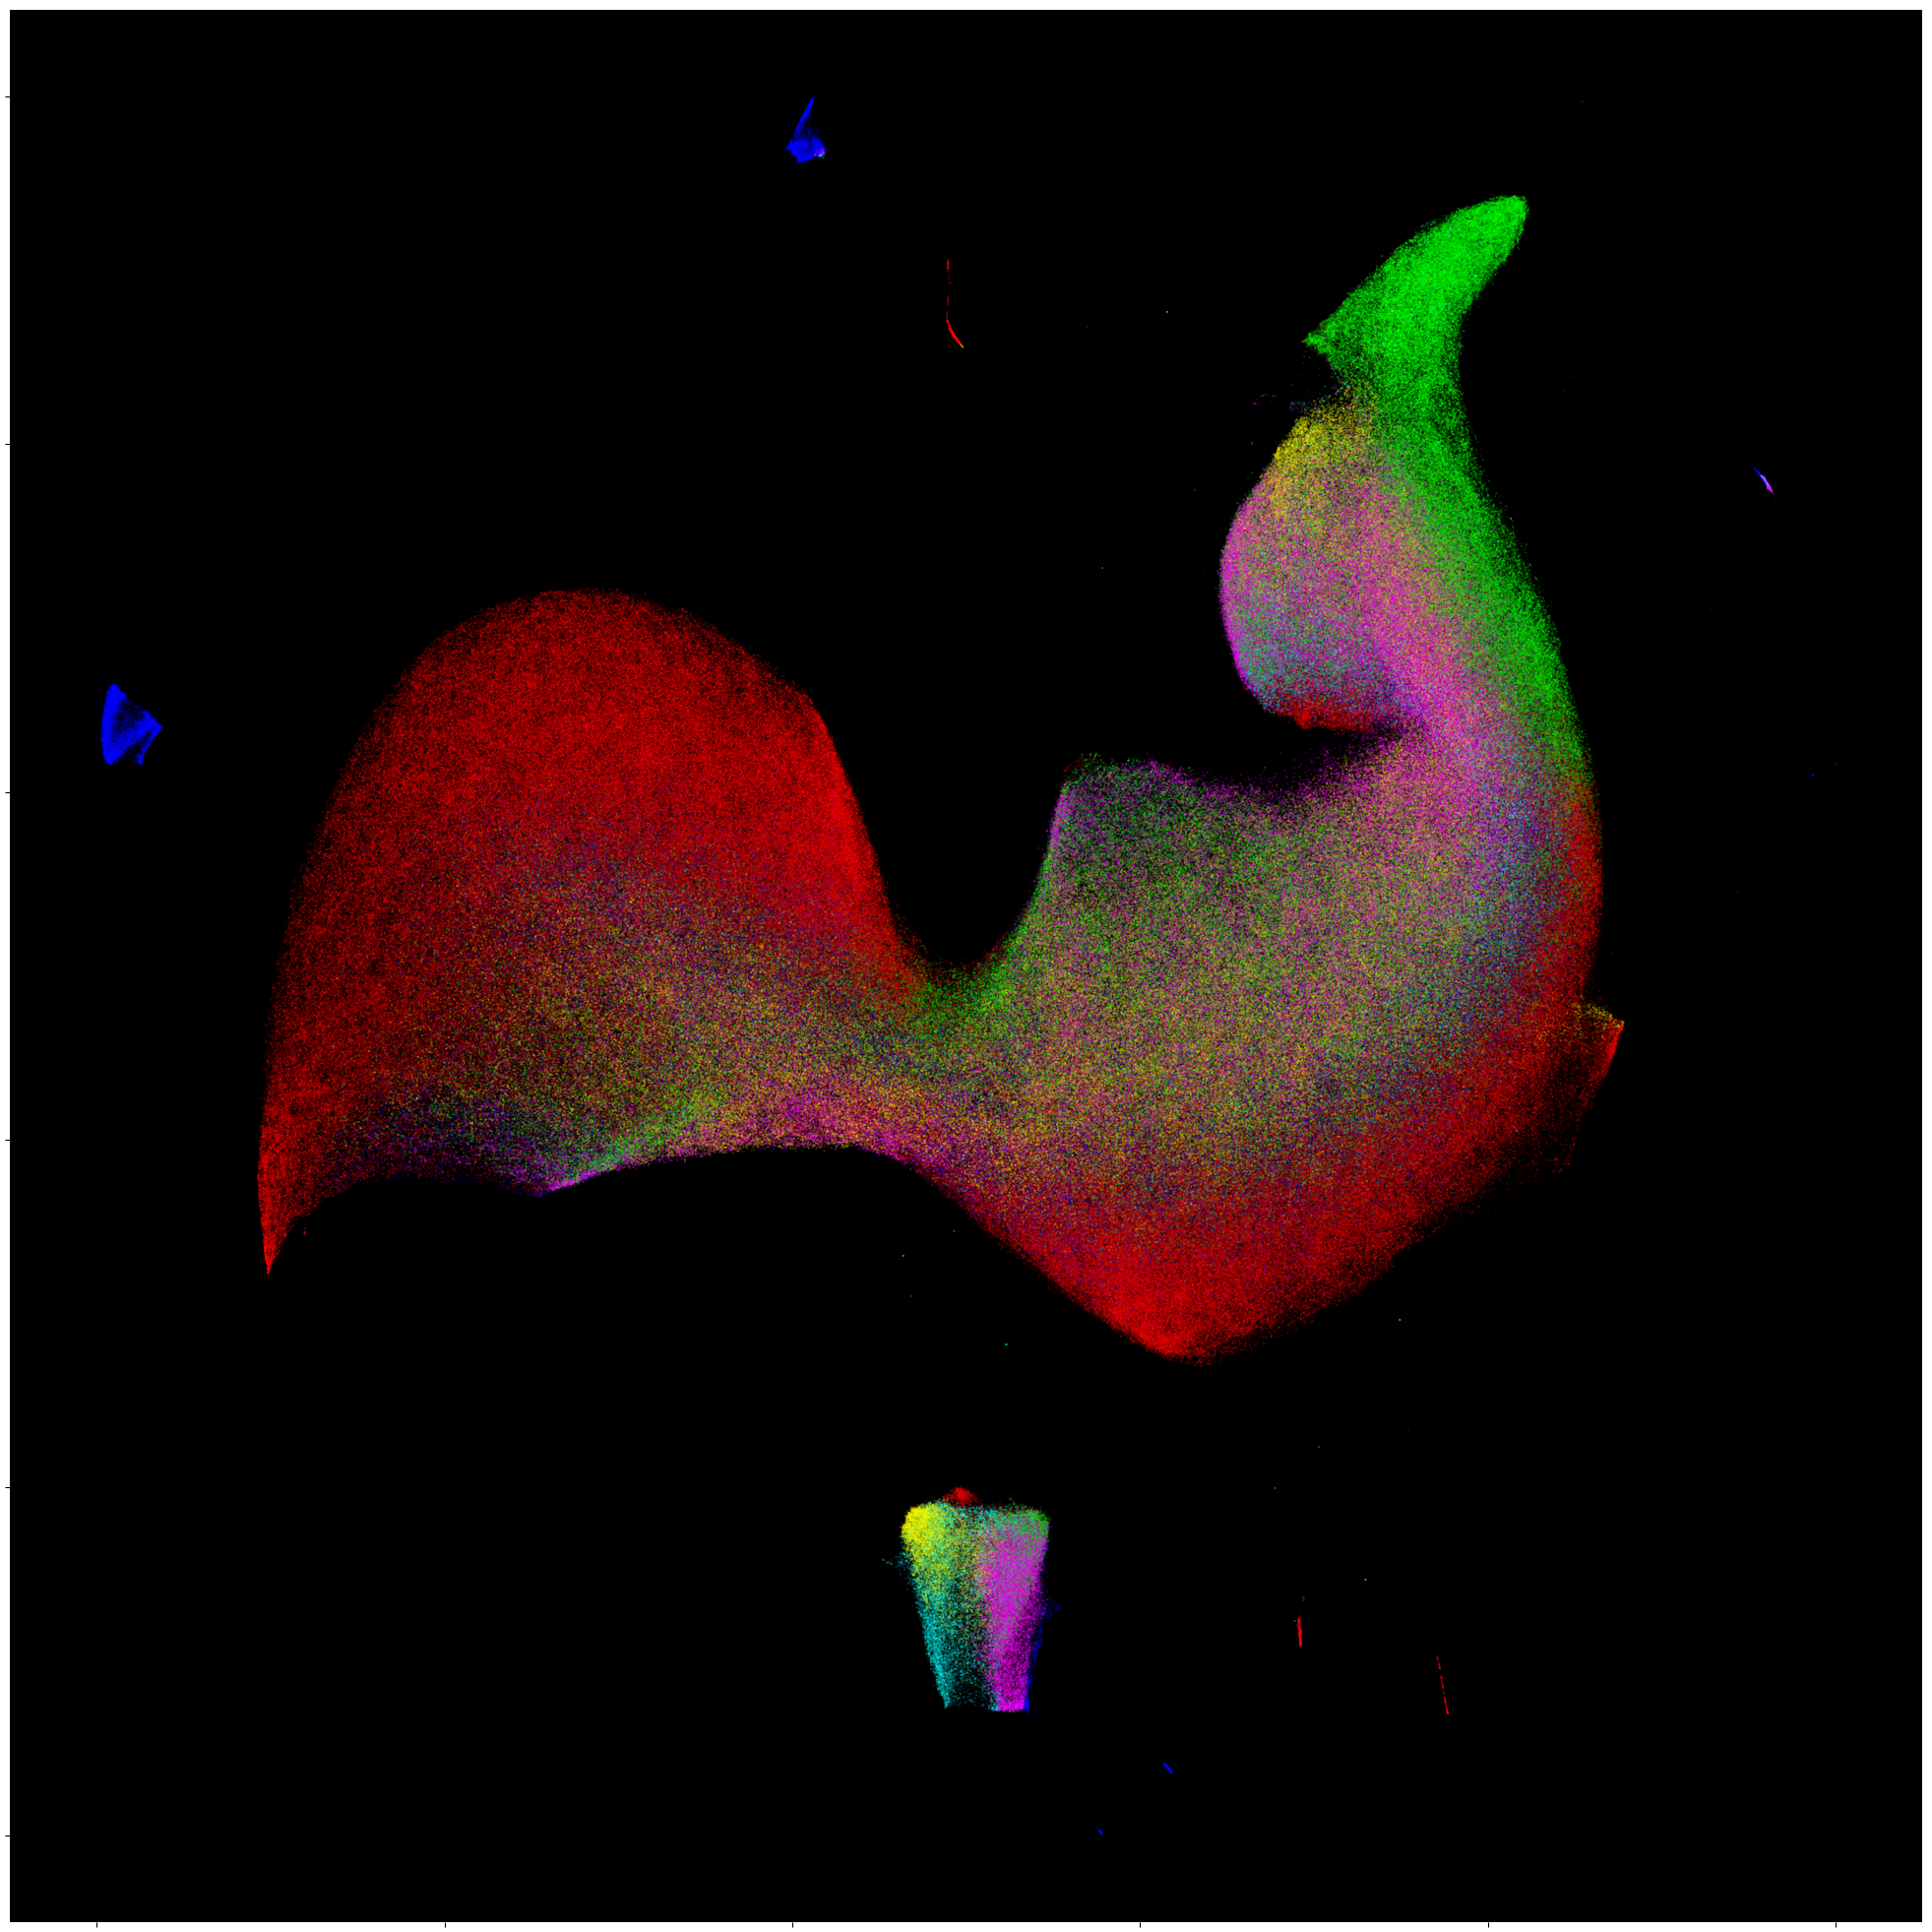

In [20]:
%matplotlib inline 

f, ax = plt.subplots(figsize=(20,20))
sns.despine(left=True, bottom=True, right=True)
ax.set_facecolor("black")
ax.scatter(MinMaxScaler(feature_range=(0,1)).fit_transform(embeddings[:,dim_a].reshape(-1, 1)),MinMaxScaler(feature_range=(0,1)).fit_transform(embeddings[:,dim_b].reshape(-1, 1)), s=0.05,c=colors_list,marker='o') 
ax.set_aspect('equal')
f.tight_layout() 


#plt.axis('off')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)



#plt.show()
plt.savefig('../../../primary_data/other_png/Figure_6_%s.png' % umap_metric,dpi=300)

